In [58]:
import pandas as pd
file = 'ENDCBSFILE.csv'
df_cbs = pd.read_csv(file, low_memory=False)

file2 = 'merged_utrecht.csv'
utrecht_df = pd.read_csv(file2)


## Utrecht

In [62]:
filtered_df = utrecht_df.copy()

filtered_df = filtered_df.dropna().reset_index(drop=True)
print(f'Number of houses after dropping missing_values: {len(filtered_df)}')

filtered = filtered_df[filtered_df["woz_2023"] < np.percentile(filtered_df["woz_2023"], 99.5)]

print(f'Number of houses after dropping high outliers in woz_2013: {len(filtered)}')
no_missing_values_df = filtered.dropna().reset_index(drop=True)

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np


def normalize_data(df):
    # Select only numerical columns
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Alternative: Standardization (mean=0, std=1)
    std_scaler = StandardScaler()
    df_standardized = std_scaler.fit_transform(df[num_cols])

    # Convert NumPy array back to DataFrame
    df_standardized = pd.DataFrame(df_standardized, columns=num_cols, index=df.index)

    return df_standardized

def convert_to_num(df):
    labelencoder = LabelEncoder()
    df['straat'] = labelencoder.fit_transform(df['straat'])
    df['buurt'] = labelencoder.fit_transform(df['buurt'])

    return df

def extract_numerical_postcode(postcode):
    # Keep only digits from the postcode
    numerical_values = ''.join(filter(str.isdigit, str(postcode)))
    return int(numerical_values) if numerical_values else None

def df_for_training(df):
    # Apply the function to extract numerical values from the postcode
    df['postcode'] = df['postcode'].apply(extract_numerical_postcode)

        # Ensure the column exists before applying the condition
    if 'grondoppervlakte' in df.columns:
        df['grondoppervlakte'] = np.where(df['grondoppervlakte'] > 0, 1, df['grondoppervlakte'])

    # Drop the 'huisnummer' column
    df = df.drop(columns=['huisnummer'], errors='ignore')  # Use errors='ignore' to avoid KeyError if the column doesn't exist

    # Encode categorical columns
    df = convert_to_num(df)
    

    #df = normalize_data(df)
    
    return df


df_train = df_for_training(no_missing_values_df)

print(df_train.info())

Number of houses after dropping missing_values: 79615
Number of houses after dropping high outliers in woz_2013: 79216
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79216 entries, 0 to 79215
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   postcode          79216 non-null  int64  
 1   straat            79216 non-null  int64  
 2   buurt             79216 non-null  int64  
 3   bouwjaar          79216 non-null  int64  
 4   grondoppervlakte  79216 non-null  float64
 5   oppervlakte       79216 non-null  int64  
 6   woz_2014          79216 non-null  float64
 7   woz_2015          79216 non-null  float64
 8   woz_2016          79216 non-null  float64
 9   woz_2017          79216 non-null  float64
 10  woz_2018          79216 non-null  float64
 11  woz_2019          79216 non-null  float64
 12  woz_2020          79216 non-null  float64
 13  woz_2021          79216 non-null  float64
 14  woz_2022       

In [67]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

def split_data_WOZ(df):
    
    y = df['woz_2023']
    X = df.drop(columns=['woz_2023'])
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # print("Training set shapes:", X_train.shape, y_train.shape)
    # print("Test set shapes:", X_test.shape, y_test.shape)

    return X_train, X_test, y_train, y_test


def rfe_feature_selection(df):
    # Split the data
    X_train, X_test, y_train, y_test = split_data_WOZ(df)
    
    # Define the model (fewer trees for faster selection)
    regressor = RandomForestRegressor(n_jobs=-1, n_estimators=50, random_state=42)

    # Use RFECV for automatic feature selection with cross-validation
    rfe = RFECV(estimator=regressor, step=5, min_features_to_select=5, cv=3, n_jobs=-1)

    # Fit RFE to select features
    rfe.fit(X_train, y_train)

    # Get selected features
    selected_features = X_train.columns[rfe.support_]
    print("Selected Features:", list(selected_features))

    # Train the model again on selected features
    regressor.fit(X_train[selected_features], y_train)
    
    # Get feature importances
    feature_importances = pd.Series(regressor.feature_importances_, index=selected_features)

    # Select the **top 5 features** based on importance
    top_5_features = feature_importances.nlargest(5)
    print("\nTop 5 Features:\n", top_5_features)

    return feature_importances, selected_features, regressor, top_5_features


# Run the function
feature_importances, selected_features, regressor, top_5_features = rfe_feature_selection(df_train)



Selected Features: ['postcode', 'straat', 'buurt', 'bouwjaar', 'grondoppervlakte', 'oppervlakte', 'woz_2014', 'woz_2015', 'woz_2016', 'woz_2017', 'woz_2018', 'woz_2019', 'woz_2020', 'woz_2021', 'woz_2022', 'latitude', 'longitude']

Top 5 Features:
 woz_2022       0.963201
oppervlakte    0.004419
woz_2021       0.003496
woz_2020       0.002836
woz_2018       0.002581
dtype: float64


In [92]:
feature_importances.nlargest(10)

woz_2022       0.963201
oppervlakte    0.004419
woz_2021       0.003496
woz_2020       0.002836
woz_2018       0.002581
woz_2019       0.002505
latitude       0.002411
longitude      0.002396
woz_2014       0.002305
woz_2017       0.002215
dtype: float64

In [ ]:
# **Plot Top 5 Feature Importances**
plt.figure(figsize=(10, 5))
top_5_features.plot.bar(color="darkslateblue")  # Set bar color
plt.ylabel("Feature Importance")
plt.title("Top 5 Most Important Features in Random Forest")
plt.show()

In [96]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

def convert_to_num(df):
    labelencoder = LabelEncoder()
    
    # Encode 'gm_naam' column
    df['gm_naam'] = labelencoder.fit_transform(df['gm_naam'])
    
    # Encode 'gwb_code' column
    df['gwb_code'] = labelencoder.fit_transform(df['gwb_code'])
    
    return df


def normalize_data(df):

    # Select only numerical columns
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Alternative: Standardization (mean=0, std=1)
    std_scaler = StandardScaler()
    df_standardized = std_scaler.fit_transform(df[num_cols])

    # Convert NumPy array back to DataFrame
    df_standardized = pd.DataFrame(df_standardized, columns=num_cols, index=df.index)


    return df_standardized



def df_for_training(df):
    # Encode categorical columns
    df = convert_to_num(df)
    
    df = df.drop(columns=['regio', 'ind_wbi'])

    #df = normalize_data(df)
    
    return df

# Apply the transformation
df_train = df_cbs.copy()
df_train = df_for_training(df_train)

print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51854 entries, 0 to 51853
Data columns (total 69 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gm_naam   51854 non-null  int64  
 1   gwb_code  51854 non-null  int64  
 2   year      51854 non-null  int64  
 3   woz       51854 non-null  float64
 4   a_inw     51854 non-null  float64
 5   a_man     51854 non-null  float64
 6   a_vrouw   51854 non-null  float64
 7   a_geb     51854 non-null  float64
 8   p_geb     51854 non-null  float64
 9   a_ste     51854 non-null  float64
 10  p_ste     51854 non-null  float64
 11  a_hh      51854 non-null  float64
 12  g_hhgro   51854 non-null  float64
 13  bev_dich  51854 non-null  float64
 14  a_woning  51854 non-null  float64
 15  p_1gezw   51854 non-null  float64
 16  p_mgezw   51854 non-null  float64
 17  p_leegsw  51854 non-null  float64
 18  p_koopw   51854 non-null  float64
 19  p_huurw   51854 non-null  float64
 20  p_wcorpw  51854 non-null  fl

In [23]:
selected_features = ['gm_naam', 'gwb_code', 'year', 'woz', 'bev_dich', 'a_woning', 'p_1gezw', 'p_koopw', 'g_ele', 'g_ele_hu', 
                     'g_ele_ko', 'g_gas_ko', 'g_ink_po', 'g_ink_pi', 'p_ink_li', 'p_hh_hi', 'p_hh_lkk', 'pst_mvp', 'ste_oad']

selected_CBS = df_train[selected_features]

In [69]:
def split_data(df, test_year):
    train_df = df[df['year'] < test_year]
    test_df = df[df['year'] == test_year]  # Use 2024 as test year
    
    # Define features and target
    X_train = train_df.drop(columns=['woz'])
    y_train = train_df['woz']
    X_test = test_df.drop(columns=['woz'])
    y_test = test_df['woz']

    return X_train, X_test, y_train, y_test

X_train_S, X_test_S, y_train_S, y_test_S = split_data(selected_CBS, 2024)
X_train, X_test, y_train, y_test = split_data(df_train, 2024)

In [70]:
def rfe_feature_selection(df):

    # Split the data
    X_train, X_test, y_train, y_test = split_data(df_train, 2024)
    
     # Define the model (fewer trees for faster selection)
    regressor = RandomForestRegressor(n_jobs=-1, n_estimators=20, random_state=42)

    # Use RFECV for automatic feature selection with cross-validation
    rfe = RFECV(estimator=regressor, step=5, min_features_to_select=10, cv=3, n_jobs=-1)

    # Fit RFE to select features
    rfe.fit(X_train, y_train)

    # Get selected features
    selected_features = X_train.columns[rfe.support_]
    print("Selected Features:", list(selected_features))

    # Train the model again on selected features
    regressor.fit(X_train[selected_features], y_train)
    predictions = regressor.predict(X_test[selected_features])

    feature_importances = pd.Series(regressor.feature_importances_, index=selected_features)

    # Select the **top 5 features** based on importance
    top_5_features = feature_importances.nlargest(5)
    print("\nTop 5 Features:\n", top_5_features)


    return feature_importances, selected_features, regressor, top_5_features

# Run the function
feature_importances_CB, selected_features_CB, regressor_CB, top_5_features_CB = rfe_feature_selection(df_train)


Selected Features: ['gm_naam', 'gwb_code', 'year', 'bev_dich', 'a_woning', 'p_1gezw', 'p_koopw', 'g_ele', 'g_ele_hu', 'g_ele_ko', 'g_gas_ko', 'g_ink_po', 'g_ink_pi', 'p_ink_li', 'p_hh_hi', 'p_hh_lkk', 'pst_mvp', 'ste_oad']

Top 5 Features:
 g_ink_pi    0.378414
g_ink_po    0.192208
g_ele       0.163546
year        0.052489
pst_mvp     0.033903
dtype: float64


g_ele_ko    0.009454
gm_naam     0.009484
g_ele_hu    0.010019
p_hh_lkk    0.010072
a_woning    0.011269
p_ink_li    0.012100
p_koopw     0.012452
gwb_code    0.013086
p_1gezw     0.014222
g_gas_ko    0.016835
ste_oad     0.017629
bev_dich    0.019180
p_hh_hi     0.023636
pst_mvp     0.033903
year        0.052489
g_ele       0.163546
g_ink_po    0.192208
g_ink_pi    0.378414
dtype: float64


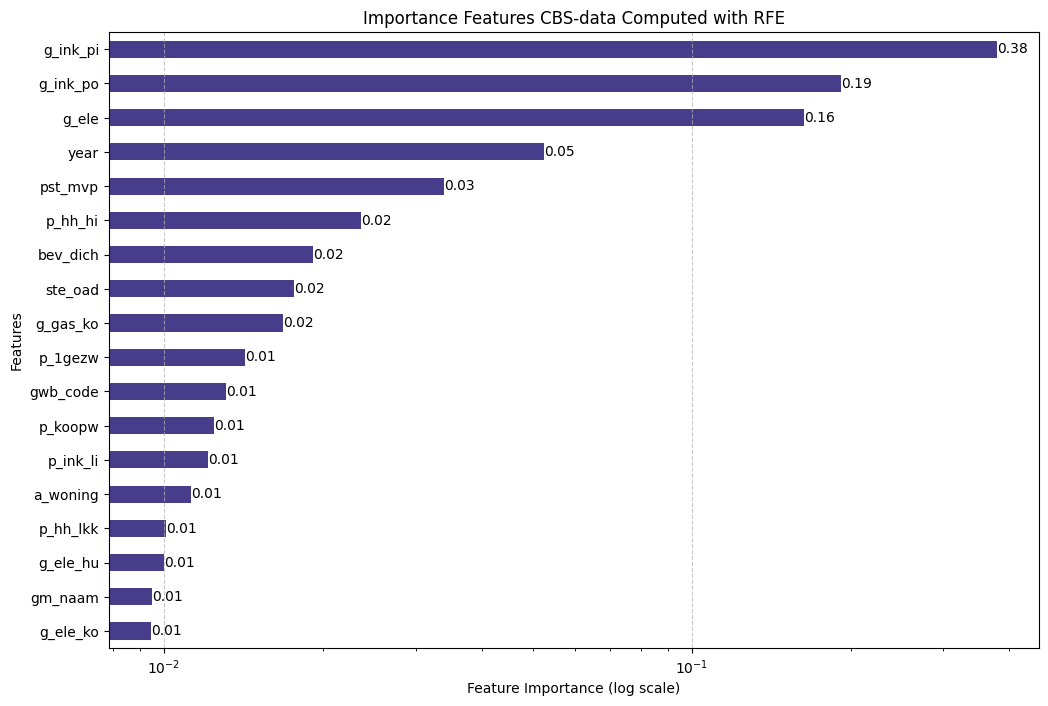

In [87]:

# Sort features from high to low
filtered_features = feature_importances_CB.sort_values(ascending=True)  # Ascending for horizontal bars
print(filtered_features)
# Plot as horizontal bar chart
plt.figure(figsize=(12, 8))
ax = filtered_features.plot(kind='barh', figsize=(12, 8), color=['darkslateblue'])

# Log scale for y-axis (feature importance)
plt.xscale('log')

# Add labels on top of bars
for bar in ax.patches:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
            f'{bar.get_width():.2f}', va='center', ha='left', fontsize=10)

# Labels and title
plt.xlabel("Feature Importance (log scale)")
plt.ylabel("Features")
plt.title("Importance Features CBS-data Computed with RFE")
plt.grid(axis='x', linestyle='--', alpha=0.7)


save_path = os.path.join(os.getcwd(), "CBSimportanceRFE.png")

plt.savefig(save_path, dpi=300)

# Show plot
plt.show()


In [24]:
def evaluate_model(y_test, y_pred):
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print results
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R2):", r2)
    
    # Display predictions alongside actual values
    results = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
    print("\nPredictions vs Actual:")
    print(results)

    return results, mse, r2

In [116]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder


def XGB(X_train, X_test, y_train):

    # Train an XGBoost Regressor
    model = XGBRegressor(n_estimators=700, learning_rate=0.1, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    # Get feature importance scores
    feature_importances = model.feature_importances_
    
    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importances
    })

    # Sort features by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # Display the top features
    print(feature_importance_df.head(10))  # Top 10 most important features
    
        
    # Predict on the test set
    #y_pred = model.predict(X_test)

    #return y_pred, feature_importance_df

    return feature_importance_df

# # Get values
# y_pred = XGB(X_train, X_test, y_train)
# result_XGB, mse_XGB, r2_XGB = evaluate_model(y_test, y_pred)

# y_pred_S = XGB(X_train_S, X_test_S, y_train_S)
# result_XGB_S, mse_XGB_S, r2_XGB_S = evaluate_model(y_test_S, y_pred_S)

In [123]:
from sklearn.ensemble import RandomForestRegressor
#Best parameters: {'n_estimators': 700, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10}
#Best Parameters Found:  {'n_estimators': 350, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}
def random_forest(X_train, X_test, y_train):
    
    rf = RandomForestRegressor(
        n_estimators=200,  # Number of trees in the forest
        random_state=42,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        warm_start=True,
        bootstrap=True,
        max_depth=40,
        n_jobs=-1  # Use all available CPU cores for parallel computation
    )

    rf.fit(X_train, y_train)

    # Get feature importances
    rf_feature_importances = rf.feature_importances_
    
    # Create DataFrame
    rf_feature_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf_feature_importances
    })
    
    # Sort by importance
    rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # Display top 10 features
    print(rf_feature_importance_df.head(10))

   # y_pred = rf.predict(X_test)
    return rf_feature_importance_df

    #return y_pred, rf_feature_importance_df
    
# # Get values
# y_pred_rf = random_forest(X_train, X_test, y_train)
# result_rf, mse_rf, r2_rf = evaluate_model(y_test, y_pred_rf)

# y_pred_S = random_forest(X_train_S, X_test_S, y_train_S)
# result_rf_S, mse_rf_S, r2_rf_S = evaluate_model(y_test_S, y_pred_S)

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def split_data_iterate_testyear(df, df_selected, first_test_year):
    unique_years = sorted(df['year'].unique())

    # y_m_R = []
    # y_m_S = []
    # y_m_P = []

    feature_importance_XGB = {}
    feature_importance_RF = {}

    for test_year in range(first_test_year, (int(unique_years[-1]) + 1)):
        print(f"Processing for test year: {test_year}")

        # Split train & test sets
        train_df = df[df['year'] < test_year]
        test_df = df[df['year'] == test_year]  

        # Define features and target
        X_train = train_df.drop(columns=['woz'])
        y_train = train_df['woz']
        X_test = test_df.drop(columns=['woz'])
        y_test = test_df['woz']

        # # Split train & test sets
        # train_df_S = df_selected[df_selected['year'] < test_year]
        # test_df_S = df_selected[df_selected['year'] == test_year]  

        # # Define features and target
        # X_train_S = train_df_S.drop(columns=['woz'])
        # y_train_S = train_df_S['woz']
        # X_test_S = test_df_S.drop(columns=['woz'])
        # y_test_S = test_df_S['woz']



        # Train & predict
        y_predf, df_imp_rf = random_forest(X_train, X_test, y_train)
        # y_pred_S = random_forest(X_train_S, X_test_S, y_train_S)
        y_pred , df_imp_XGB = XGB(X_train, X_test, y_train)
        #y_pred_S = XGB(X_train_S, X_test_S, y_train_S)

        # Evaluate


        feature_importance_RF[test_year] = df_imp_rf[['Feature', 'Importance']].to_dict(orient="records")
        feature_importance_XGB[test_year] = df_imp_XGB[['Feature', 'Importance']].to_dict(orient="records")



    return feature_importance_RF, feature_importance_XGB
# Run the function
#y_m_R, y_m_P, y_m_S = split_data_iterate_testyear(df_train, selected_CBS, 2015)
#y_m_RR, y_m_PR, y_m_SR = split_data_iterate_testyear(df_train, selected_CBS, 2015)
feature_importance_RF, feature_importance_XGB = split_data_iterate_testyear(df_train, selected_CBS, 2015)


Processing for test year: 2015
     Feature  Importance
31  g_ink_pi    0.090304
30  g_ink_po    0.085236
35   p_hh_hi    0.074741
25     g_gas    0.072036
21     g_ele    0.070681
28  g_gas_ko    0.063079
33  p_ink_hi    0.057017
24  g_ele_ko    0.049866
19  p_wcorpw    0.029947
27  g_gas_hu    0.028105
     Feature  Importance
21     g_ele    0.165593
31  g_ink_pi    0.154725
25     g_gas    0.153539
28  g_gas_ko    0.115682
35   p_hh_hi    0.096966
30  g_ink_po    0.052077
23  g_ele_hu    0.021467
64   pst_mvp    0.017859
50     a_pau    0.010870
10      a_hh    0.009479
Processing for test year: 2016
     Feature  Importance
31  g_ink_pi    0.086251
30  g_ink_po    0.077370
35   p_hh_hi    0.077133
25     g_gas    0.073457
21     g_ele    0.070238
24  g_ele_ko    0.068339
28  g_gas_ko    0.062215
33  p_ink_hi    0.054414
19  p_wcorpw    0.035222
27  g_gas_hu    0.022391
     Feature  Importance
21     g_ele    0.234614
31  g_ink_pi    0.105637
25     g_gas    0.097555
30  g_ink_po 

KeyboardInterrupt: 

In [128]:
# Train het model op de volledige dataset (inclusief 2024)
X_full = df_train.drop(columns=["woz"])
y_full = df_train["woz"]

full_importance_XGB = {}
full_importance_RF = {}

df_imp_rf_FULL = random_forest(X_full, X_full,  y_full)
df_imp_XGB_FULL = XGB(X_full, X_full, y_full)

full_importance_RF[2024] = df_imp_rf_FULL[['Feature', 'Importance']].to_dict(orient="records")
full_importance_XGB[2024] = df_imp_XGB_FULL[['Feature', 'Importance']].to_dict(orient="records")

# # Convert full importance dictionaries to DataFrames
# df_full_RF = pd.DataFrame(list(full_importance_RF.items()), columns=['Feature', 'Full Importance RF'])
# df_full_XGB = pd.DataFrame(list(full_importance_XGB.items()), columns=['Feature', 'Full Importance XGB'])



     Feature  Importance
31  g_ink_pi    0.170656
30  g_ink_po    0.147964
35   p_hh_hi    0.065789
33  p_ink_hi    0.055223
2       year    0.051884
21     g_ele    0.044161
24  g_ele_ko    0.031950
19  p_wcorpw    0.023276
38  a_soz_wb    0.022748
64   pst_mvp    0.022176
     Feature  Importance
31  g_ink_pi    0.260765
30  g_ink_po    0.220782
21     g_ele    0.085045
12  bev_dich    0.061196
2       year    0.042846
35   p_hh_hi    0.033984
38  a_soz_wb    0.025171
64   pst_mvp    0.017217
28  g_gas_ko    0.014771
24  g_ele_ko    0.013838


<Figure size 1200x600 with 0 Axes>

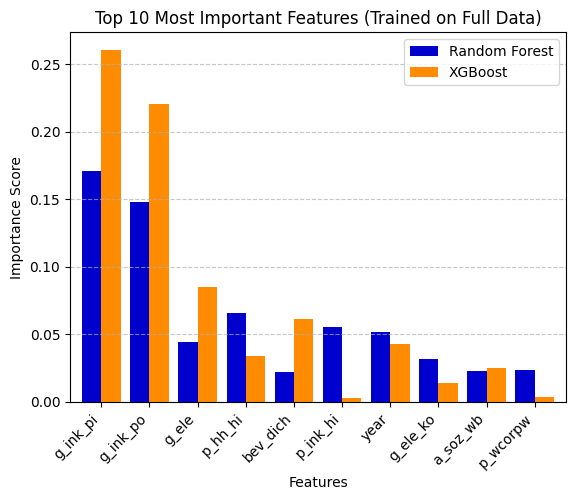

In [133]:
# Ensure full_importance_RF and full_importance_XGB exist
full_importance_RF = {2024: df_imp_rf_FULL[['Feature', 'Importance']].to_dict(orient="records")}
full_importance_XGB = {2024: df_imp_XGB_FULL[['Feature', 'Importance']].to_dict(orient="records")}

# Convert full importance lists into DataFrames
df_full_RF = pd.DataFrame(full_importance_RF[2024])  # Convert list of dicts to DataFrame
df_full_XGB = pd.DataFrame(full_importance_XGB[2024])  # Convert list of dicts to DataFrame

# Rename importance columns
df_full_RF.rename(columns={'Importance': 'Full Importance RF'}, inplace=True)
df_full_XGB.rename(columns={'Importance': 'Full Importance XGB'}, inplace=True)

# Merge both DataFrames on the 'Feature' column
df_combined_full = pd.merge(df_full_RF, df_full_XGB, on="Feature", how="outer").fillna(0)

# Set index to 'Feature' for plotting
df_combined_full.set_index("Feature", inplace=True)

# Select the top 10 most important features for each model
top_n = 10

# Select the top N features by highest importance in either RF or XGB
df_top_features = df_combined_full.copy()
df_top_features["Max Importance"] = df_top_features[["Full Importance RF", "Full Importance XGB"]].max(axis=1)
df_top_features = df_top_features.sort_values(by="Max Importance", ascending=False).head(top_n)

# Drop the helper column
df_top_features.drop(columns=["Max Importance"], inplace=True)

# Define colors for the bar plot
colors = ["mediumblue", "darkorange"]  # Blue for RF, Orange for XGB

# Create the plot for top full importance features
plt.figure(figsize=(12, 6))
df_top_features.plot(kind='bar', width=0.8, color=colors)
plt.title(f"Top {top_n} Most Important Features (Trained on Full Data)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha="right")
plt.legend(["Random Forest", "XGBoost"])
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()


In [112]:
cumulative_importance_RF = {}
cumulative_importance_XGB = {}

# Process each year and accumulate feature importance scores
for year in feature_importance_RF.keys():
    for entry in feature_importance_RF[year]:
        feature = entry['Feature']
        importance = entry['Importance']
        cumulative_importance_RF[feature] = cumulative_importance_RF.get(feature, 0) + importance

for year in feature_importance_XGB.keys():
    for entry in feature_importance_XGB[year]:
        feature = entry['Feature']
        importance = entry['Importance']
        cumulative_importance_XGB[feature] = cumulative_importance_XGB.get(feature, 0) + importance

# Convert cumulative dictionaries to DataFrames
df_cum_RF = pd.DataFrame(list(cumulative_importance_RF.items()), columns=['Feature', 'Cumulative Importance RF'])
df_cum_XGB = pd.DataFrame(list(cumulative_importance_XGB.items()), columns=['Feature', 'Cumulative Importance XGB'])

# Merge both DataFrames for easier comparison
df_cum_combined = pd.merge(df_cum_RF, df_cum_XGB, on="Feature", how="outer").fillna(0)

# Sort by highest cumulative importance in either model
df_cum_combined = df_cum_combined.set_index("Feature").sort_values(by=["Cumulative Importance RF", "Cumulative Importance XGB"], ascending=False)


In [137]:
# # Convert full importance dictionaries to DataFrames
# df_full_RF = pd.DataFrame(list(full_importance_RF.items()), columns=['Feature', 'Full Importance RF'])
# df_full_XGB = pd.DataFrame(list(full_importance_XGB.items()), columns=['Feature', 'Full Importance XGB'])

# # Merge cumulative and full importance for comparison
# df_combined_full = pd.merge(df_full_RF, df_full_XGB, on="Feature", how="outer").fillna(0)
# # df_combined = pd.merge(df_combined, df_full_XGB, on="Feature", how="outer").fillna(0)

# Create subplots to display the cumulative and full importance plots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Define custom colors
colors = ["darkslateblue", "#ff7f0e"]  # Cumulative colors
#colors_full = ["mediumblue", "darkorange"]  # Full importance colors

# Plot cumulative importance (left)
df_cum_combined[["Cumulative Importance RF", "Cumulative Importance XGB"]].plot(
    kind='bar', ax=axes[0], width=0.8, color=colors)
axes[0].set_title("Cumulative Feature Importance (Over Time)")
axes[0].set_ylabel("Importance Score")
axes[0].set_xlabel("Features")
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(["Random Forest", "XGBoost"])
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Plot full importance (right)
df_top_features[["Full Importance RF", "Full Importance XGB"]].plot(
    kind='bar', ax=axes[1], width=0.8, color=colors)
axes[1].set_title("Feature Importance (Trained on Full Data)")
axes[1].set_xlabel("Features")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(["Random Forest", "XGBoost"])
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

save_path = os.path.join(os.getcwd(), "FEUTUreModel.png")

plt.savefig(save_path, dpi=300)


# Adjust layout
plt.tight_layout()
plt.show()


In [89]:
import matplotlib.pyplot as plt
test_years = list(range(2015, 2025))

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# First plot (original)
axes[0].plot(test_years, y_m_R, marker='o', linestyle='-', color='darkslateblue', label='Actual WOZ')
axes[0].plot(test_years, y_m_P, marker='s', linestyle='--', color='slateblue', label='Predicted without RFE')
axes[0].plot(test_years, y_m_S, marker='^', linestyle=':', color='orange', label='Predicted With RFE')

axes[0].set_xlabel("Year")
axes[0].set_ylabel("Mean WOZ Value")
axes[0].set_title("Actual vs. Predicted WOZ (XGBoost Model)")
axes[0].legend()
axes[0].grid(True)

# Second plot (change variables accordingly)
axes[1].plot(test_years, y_m_RR, marker='o', linestyle='-', color='darkslateblue', label='Actual WOZ')
axes[1].plot(test_years, y_m_PR, marker='s', linestyle='--', color='slateblue', label='Predicted without RFE')
axes[1].plot(test_years, y_m_SR, marker='^', linestyle=':', color='orange', label='Predicted With RFE')

axes[1].set_xlabel("Year")
axes[1].set_ylabel("Mean WOZ Value")
axes[1].set_title("Actual vs. Predicted WOZ (RF Model)")
axes[1].legend()
axes[1].grid(True)

save_path = os.path.join(os.getcwd(), "MeanWOZPred.png")

plt.savefig(save_path, dpi=300)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [90]:
import os


# Now show the plot
plt.show()

print(f"Plot saved as {save_path}")



Plot saved as /home/wouter/Documents/Scriptie/Plot performance/MeanWOZPred.png


In [25]:
print(len(y_m_R))

11


In [54]:
import matplotlib.pyplot as plt
import numpy as np
def plot_m_r(mse_scores, r2_scores):
    # Example values for different models (replace these with your actual values)
    models = ['XGBoost', 'XGBoost (REF)', 'Random Forest', 'Random Forest (REF)']

    # Set up the plot
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Bar plot for R² scores
    bar_width = 0.2
    index = np.arange(len(models))
    
    bar1 = ax1.bar(index, r2_scores, bar_width, label='R²', color='slateblue', alpha=0.9)
    
    # Create a second y-axis for MSE scores
    ax2 = ax1.twinx()
    bar2 = ax2.bar(index + bar_width, mse_scores, bar_width, label='MSE', color='orange', alpha=0.9)
    
    # Set labels
    ax1.set_xlabel('Model (With and Without REF Applied)')
    ax1.set_ylabel('R²', color='slateblue')
    ax2.set_ylabel('MSE', color='orange')
    
    # Add some labels and titles
    ax1.set_xticks(index + bar_width / 2)
    ax1.set_xticklabels(models)
    ax1.set_title('Comparison of R² and MSE for XGBoost and RF')


    # Show legends
    ax1.legend(loc='lower left')
    ax2.legend(loc='lower right')

    # Add annotations (rounded values) on top of bars
    for bar in bar1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=8, color='slateblue')

    for bar in bar2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=8, color='orange')


    save_path = os.path.join(os.getcwd(), "ComparisonCBS.png")
    plt.savefig(save_path, dpi=300)

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_m_r([mse_XGB, mse_XGB_S, mse_rf, mse_rf_S], [r2_XGB, r2_XGB_S, r2_rf, r2_rf_S])